<a href="https://colab.research.google.com/github/rajatdua/dlvr-fgmccb/blob/triplet-loss/DLVR_Project_FGMCCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Visual Recognition Project

In this project, We will utilize the Caltech-UCSD Birds 200 (CUB-200-2011) dataset, which comprises a total of 11,788 images depicting 200 distinct bird species. The dataset exhibits a notably **balanced distribution**, with 50 to 60 images available for each individual species. It includes detailed annotations specifying the locations of specific anatomical parts of the birds.

## Fine Grained Multi-Class Classification of Birds (FGMCCB)

Our primary focus will be on employing **EfficientNetB5** for image encoding and implementing a decoder for classification. Due to the inherent similarities among bird features and the challenge of distinguishing them, we will employ the **Triplet Loss**. This loss function encourages the network to minimize the distance between anchor and positive samples while increasing the separation from negative samples within the embedding space. In addition, we will also leverage the **Cross-Entropy Loss**.

### Dataset Classification

#### Source
You can find the source dataset from [here](http://www.vision.caltech.edu/datasets/cub_200_2011/).

#### Details
- Number of categories: 200
- Number of images: 11,788
- Input image dimensions: 224 x 224
- Annotations per image: 15 Part Locations, 312 Binary Attributes, 1 Bounding Box

#### Tech-Stack
- Language: Python
- Framework: PyTorch




#### **Step 1: Data Pre-Processing**

1. Mount the google drive and download the dataset
2. Divide the dataset in training, validation and testing datasets

**Note**: Use data augumentation to increase the dataset working space

##### **Step 1.1: Mount the google drive and download the dataset**

### Environment variables

In [7]:
import os

in_colab = False

if os.getenv("COLAB_RELEASE_TAG"):
   in_colab = True

in_colab

True

### Prerequisite libraries

In [8]:
if not in_colab:
    !pip install google
# common
!pip install tqdm

In [9]:
import os
import requests
from tqdm import tqdm
import tarfile

# Mount Google Drive
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

# Define the dataset URL
dataset_url = "https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1"

# Define the local directory to save the dataset
# local_dir = '/content/dataset'
download_dir = '/content/drive/My Drive/Datasets' if in_colab else './Datasets'

dataset_file = 'CUB_200_2011.tgz'
extracted_folder = 'CUB_200_2011'

# Check if the directory already exists
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Check if the directory is empty - removed this because it is more robust to check
# if not os.listdir(local_dir):

# Check if the dataset file and folder exist
if not os.path.exists(os.path.join(download_dir, dataset_file)):
    # Download the dataset
    response = requests.get(dataset_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB
    t = tqdm(total=total_size, unit='iB', unit_scale=True)
    with open(os.path.join(download_dir, 'CUB_200_2011.tgz'), 'wb') as file, tqdm(
        desc='Downloading',
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            t.update(len(data))
            bar.update(len(data))
            file.write(data)
    t.close()

if not os.path.exists(os.path.join(download_dir, extracted_folder)):
    # Extract the dataset
    with tarfile.open(os.path.join(download_dir, 'CUB_200_2011.tgz'), 'r:gz') as tar:
        tar.extractall(download_dir)
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists in the directory. Skipping download and extraction.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already exists in the directory. Skipping download and extraction.


In [10]:
import os

# List files in /content/drive/My Drive/Datasets folder
print(f"\nFiles in {download_dir} folder:")
for file in os.listdir(download_dir):
    print(file)

# List files in /content/drive/My Drive/Datasets/CUB_200_2011 folder
print(f"\nFiles in {download_dir}/{extracted_folder} folder:")
for file in os.listdir(f'{download_dir}/{extracted_folder}'):
    print(file)



Files in /content/drive/My Drive/Datasets folder:
attributes.txt
CUB_200_2011.tgz
CUB_200_2011
CUB_200_2011_divided

Files in /content/drive/My Drive/Datasets/CUB_200_2011 folder:
parts
images.txt
train_test_split.txt
bounding_boxes.txt
classes.txt
image_class_labels.txt
attributes
README
images


### Step 1.3: Average Image Distribution for Best Data Augumentation Strategy

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


# Set the path to the CUB-200-2011 dataset
dataset_path = f"{download_dir}/{extracted_folder}"

# Function to load and resize images
def load_and_resize_image(file_path, target_size):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    return img

# Get the list of subfolders (bird categories) in the "images" directory
subfolders = [f for f in os.listdir(os.path.join(dataset_path, "images")) if os.path.isdir(os.path.join(dataset_path, "images", f))]

# Specify the target size for resizing
target_size = (224, 224)  # You can adjust this based on your requirements

# Initialize an array to store resized images
resized_images = []

# Resize and load images from each subfolder
for subfolder in tqdm(subfolders, desc="Resizing images"):
    subfolder_path = os.path.join(dataset_path, "images", subfolder)
    # Get the list of image files in the subfolder
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg')]

    # Load and resize images
    for img_file in image_files:
        img_path = os.path.join(subfolder_path, img_file)
        resized_img = load_and_resize_image(img_path, target_size)
        resized_images.append(resized_img)

# Stack the images to calculate the average
stacked_images = np.stack(resized_images, axis=0)

# Calculate the average image
average_image = np.mean(stacked_images, axis=0).astype(np.uint8)

# Display the average image
# cv2.imshow("Average Image", cv2.cvtColor(average_image, cv2.COLOR_RGB2BGR))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(average_image)
plt.axis('off')  # Turn off axis labels
plt.show()


Resizing images:   0%|          | 0/200 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

As seen above, the images are center biased. Majority of the bird images are in the middle. We would need to overcome this problem since we need to focus on other parts of the image.

### Preprocessing dataset to remove background using boundary boxes

In [ ]:
import cv2
import os
import numpy as np

dataset_path = f"{download_dir}/{extracted_folder}"
subfolders = [f for f in os.listdir(os.path.join(dataset_path, "images")) if os.path.isdir(os.path.join(dataset_path, "images", f))]

images_path = "./Datasets/CUB_200_2011/images"
output_dir = "./Datasets/CUB_200_2011/processed-images"
boxes_file = "./Datasets/CUB_200_2011/bounding_boxes.txt"  # Update with the correct path

os.makedirs(output_dir, exist_ok=True)

boundary_dict = {}

with open(boxes_file, 'r') as file:
    for line in file:
        all_details = line.strip().split()
        boundary_dict[all_details[0]] = {
            'x': int(float(all_details[1])),
            'y': int(float(all_details[2])),
            'width': int(float(all_details[3])),
            'height': int(float(all_details[4])),
        }

def capitalize_before_underscore(text):
    words = text.split('_')
    capitalized_words = [word.capitalize() for word in words]
    return '_'.join(capitalized_words)

# folder = 001.Black_footed_Albatross
for folder in subfolders:
    folder_details = folder.split('.')
    # had to capitalise it because the folder name and image names are same but not same case
    name_of_bird = capitalize_before_underscore(folder_details[1])
    selected_image_path = os.path.join(images_path, folder)
    # selected_image = Crested_Auklet_0045_794940.jpg (Example)
    for selected_image in os.listdir(selected_image_path):
        full_selected_image_path = os.path.join(selected_image_path, selected_image)
        # <name_of_bird>_<image_number>_<random_number>.jpg; the image_number is extracted by splitting the name of the bird and then splitting it with _
        image_number = selected_image.split(name_of_bird)[1].split('_')[1]
        boundary_box_for_image = boundary_dict[f"{int(image_number)}"]
        img = cv2.imread(full_selected_image_path)
        x, y, width, height = boundary_box_for_image["x"], boundary_box_for_image["y"], boundary_box_for_image["width"], boundary_box_for_image["height"]

        # Create a binary mask with 1s inside the boundary box and 0s outside
        mask = np.zeros_like(img, dtype=np.uint8)
        mask[y:y+height, x:x+width] = 1

        # Apply the mask to the original image
        background = np.ones_like(img) * 255

        # Use the mask to combine the original image and the background
        result = img * mask + background * (1 - mask)

        # result = img * mask
        # Save the result to the output directory
        new_subfolder_dir = f"{output_dir}/{folder}"
        os.makedirs(new_subfolder_dir, exist_ok=True)
        output_path = os.path.join(output_dir, folder, selected_image)
        cv2.imwrite(output_path, result)
print("Background removal complete.")


Background removal complete.


#### **Step 2: Basic EfficientB5 Baseline**

## Baseline Version 2

### Downloading Prerequisite
1. efficientnet_pytorch - Contains all the efficient-net models.
2. torchinfo - Formats the model summary in a viewable manner.
3. matplotlib - For plotting graphs, etc.
4. opencv-python - For random occlusions.
5. seaborn - For generating a heatmap.

In [11]:
!pip install efficientnet_pytorch
if in_colab:
    !pip install torch torchvision --upgrade
else:
    !pip install torch torchvision
!pip install torchinfo
!pip install matplotlib
!pip install opencv-python
!pip install seaborn

### Imports

In [12]:
import torch
import time
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from efficientnet_pytorch import EfficientNet
from torch.utils.data.dataset import random_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import torchinfo
import numpy as np
import cv2
from PIL import Image
import random
import hashlib


#### For data augmentation

In [13]:
class RandomOcclusion(object):
    def __init__(self, occlusion_prob=0.5, max_occlusion_size=0.2):
        self.occlusion_prob = occlusion_prob
        self.max_occlusion_size = max_occlusion_size

    def __call__(self, image):
        if np.random.rand() < self.occlusion_prob:
            h, w, _ = image.shape
            occlusion_mask = np.ones((h, w, 3), dtype=np.uint8)
            occlusion_size = int(self.max_occlusion_size * min(h, w))

            # Randomly select the position of the occlusion
            top = np.random.randint(0, h - occlusion_size)
            left = np.random.randint(0, w - occlusion_size)

            # Apply occlusion (e.g., black rectangle)
            occlusion_mask[top:top + occlusion_size, left:left + occlusion_size, :] = 0
            image = cv2.add(image, occlusion_mask)

        return image

[('warbler', {'count': 25, 'child': ['bay_breasted', 'black_and_white', 'black_throated_blue', 'blue_winged', 'canada', 'cape_may', 'cerulean', 'chestnut_sided', 'golden_winged', 'hooded', 'kentucky', 'magnolia', 'mourning', 'myrtle', 'nashville', 'orange_crowned', 'palm', 'pine', 'prairie', 'prothonotary', 'swainson', 'tennessee', 'wilson', 'worm_eating', 'yellow'], 'id': ['158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182']}), ('sparrow', {'count': 21, 'child': ['baird', 'black_throated', 'brewer', 'chipping', 'clay_colored', 'house', 'field', 'fox', 'grasshopper', 'harris', 'henslow', 'le_conte', 'lincoln', 'nelson_sharp_tailed', 'savannah', 'seaside', 'song', 'tree', 'vesper', 'white_crowned', 'white_throated'], 'id': ['113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133'

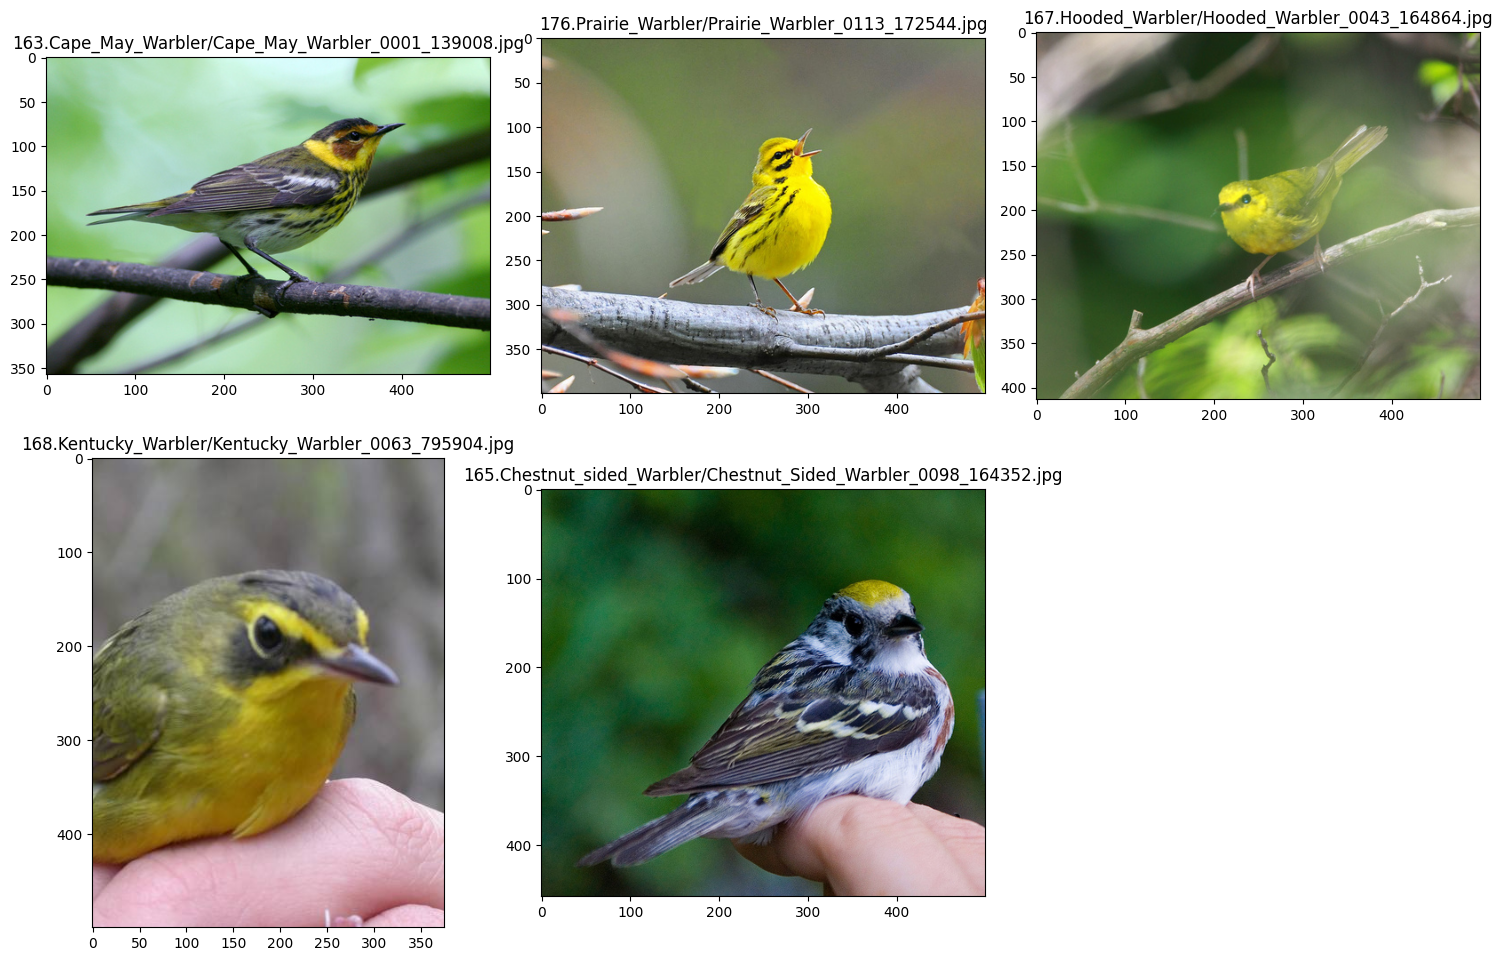

In [14]:
def process_classes_file(classes_file):
    parent_count = {}
    classes_file = f"{download_dir}/CUB_200_2011/classes.txt"
    images_file = f"{download_dir}/CUB_200_2011/images.txt"

    with open(classes_file, 'r') as file:
        for line in file:
            all_details_classes = line.strip().split()
            class_id_and_name = all_details_classes[1]
            class_name = class_id_and_name.split('.')[1].lower()
            classification = class_name.split('_')
            child_class_key = '_'.join(classification[:-1])
            parent_class_key = classification[-1]

            if parent_class_key in parent_count:
                parent_count[parent_class_key]['count'] += 1
                parent_count[parent_class_key]['id'].append(all_details_classes[0])
                parent_count[parent_class_key]['child'].append(child_class_key)
            else:
                parent_count[parent_class_key] = {'count': 1, 'child': [child_class_key], 'id': [all_details_classes[0]]}

    sorted_parents = sorted(parent_count.items(), key=lambda x: x[1]['count'], reverse=True)

    return sorted_parents


def select_top_parent(sorted_parents, index=0):
    if 0 <= index < len(sorted_parents):
        selected_parent_class = sorted_parents[index][0]
        selected_child_ids = sorted_parents[index][1]['id']
        selected_child_class = sorted_parents[index][1]['child']

        return selected_parent_class, selected_child_ids, selected_child_class
    else:
        raise ValueError("Invalid index. It should be between 0 and {}.".format(len(sorted_parents) - 1))

# Example usage:
classes_file = "path/to/your/classes_file.txt"
sorted_parents = process_classes_file(classes_file)

print(sorted_parents)

# Select the top parent (index=0)
selected_parent_class, selected_child_ids, selected_child_class = select_top_parent(sorted_parents)
print("Selected Parent Class:", selected_parent_class)
print("Selected Child IDs:", selected_child_ids)
print("Selected Child Class:", selected_child_class)

print(selected_child_class)

# print(" " + selected_parent_class + " " selected_child_ids + " " + selected_child_class)

import random
combined_array = list(zip(selected_child_ids, selected_child_class))
random_sample = random.sample(combined_array, 5)
resultant_child_id, resultant_child_names = zip(*random_sample)

import re
images_to_show = []
classes_file = f"{download_dir}/CUB_200_2011/classes.txt"
images_file = f"{download_dir}/CUB_200_2011/images.txt"

for child_id, child_name in zip(resultant_child_id, resultant_child_names):
    pattern = re.compile(f"{re.escape(child_id)}.{re.escape(child_name)}_{re.escape(selected_parent_class)}", re.IGNORECASE)
    # Open and read the text file
    with open(images_file, "r") as file:
        for line in file:
            if pattern.search(line):
                images_to_show.append(line.strip().split()[1])
                break

import matplotlib.pyplot as plt
import cv2

# Set up the figure and axis
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig, axs = plt.subplots(2, 3, figsize=(15, 10))


# Flatten the 2D array of axes
axs = axs.flatten()

# Iterate over image paths and plot each image
for i, image_path in enumerate(images_to_show):
    # Read the image
    img = cv2.imread(os.path.join(download_dir,extracted_folder,'images',image_path))

    # Plot the image
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Set title with image path0
    axs[i].set_title(image_path)

    # Set x and y axis labels
    # axs[i].set_xlabel("X-coordinate")
    # axs[i].set_ylabel("Y-coordinate")

# Remove empty subplots if any
for i in range(len(images_to_show), len(axs)):
    axs[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()



# print('---All Classes (Sorted)---')
#
# for parent_key, data in sorted_parents:
#     print(f"Parent Key: {parent_key}")
#     print(f"Class ID: {', '.join(data['id'])}")
#     print(f"Count: {data['count']}")
#     print("Children:")
#     for child in data['child']:
#         print(f"  - {child}")
#     print()



In [15]:

class Dataset_Triplet():
    def __init__(self, df, path, train=True, transform=None):
        self.data = df
        self.is_train = train
        self.transform = transform
        self.path = path

        if self.is_train:
          # Create a DataLoader for convenience
          data_loader = DataLoader(self, batch_size=len(self), shuffle=False)
          # Iterate through the DataLoader to get all images, labels, and indices

          for batch in data_loader:
              self.images, self.labels, *_ = batch
              self.indices = list(range(len(self)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        classes_file = f"{download_dir}/CUB_200_2011/classes.txt"
        images_file = f"{download_dir}/CUB_200_2011/images.txt"

        anchor_image_path = self.data.dataset.samples[index][0] #/content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg

        # Find the index of "/images/"
        index = anchor_image_path.find("/images/") + len("/images/")

        # Extract the desired portion of the path
        anchor_class = anchor_image_path[index:].split('/')[0] #001.Black_footed_Albatross
        anchor_parent = anchor_class.split("_")[-1].lower() #albatros
        anchor_label = anchor_class.strip('0').split(".")[0]

        ###### Anchor Image #######
        anchor_img = Image.open(anchor_image_path).convert('RGB')

        ###### Positive Image #######

        positive_list = [path for path, _ in dataset.samples if anchor_class in path]

        if positive_list is not None:
          positive_image_path = anchor_image_path

          while anchor_image_path == positive_image_path:
            positive_image_path = random.choice(positive_list)

          # print("positive image path: " + positive_image_path)
        else:
          # Handle situation when no other images
          print(f"No files with '{anchor_class}' found in the specified path.")
          return None

        positive_img = Image.open(positive_image_path).convert('RGB')

      ###### Negative Image #######

        if self.is_train:
            def get_ids_by_parent(data, parent_name):
              for parent, details in data:
                if parent == parent_name:
                  return details['id']
              return None

            negative_list = get_ids_by_parent(sorted_parents, anchor_parent)

            if negative_list is not None:

              if str(anchor_label) in negative_list:
                negative_list.remove(str(anchor_label))

              # Read the file and store the lines in a list
              with open(classes_file, 'r') as file:
                  lines = file.readlines()
              try:
                # Select a random line index
                random_line_index = random.choice(negative_list)
                # Get the randomly selected line
                random_line = lines[int(random_line_index) - 1]

                # Extract the relevant information (number and label)
                line_parts = random_line.split()
                number = line_parts[0]
                selected_label = ' '.join(line_parts[1:])

                # Filter images with paths containing the selected label
                filtered_paths = [path for path, label in dataset.samples if selected_label in path]

              except IndexError:
                filtered_paths = [path for path, _ in dataset.samples if anchor_parent.lower() not in path.lower()]
            else:
              filtered_paths = [path for path, _ in dataset.samples if anchor_parent.lower() not in path.lower()]


            # Select a random image path from the filtered paths
            negative_image_path = random.choice(filtered_paths)

            # print("negative image path: " + negative_image_path)

            # Load the corresponding image using the selected path
            negative_img = Image.open(negative_image_path).convert('RGB')

            if self.transform!=None:
                anchor_img = self.transform(anchor_img)
                positive_img = self.transform(positive_img)
                negative_img = self.transform(negative_img)
        return anchor_img, positive_img, negative_img, anchor_label

#### Begin baseline version model

Preparing dataset
Splitting dataset
('/content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0007_796138.jpg', 0)
Loader setup
Dataset path /content/drive/MyDrive/Datasets/CUB_200_2011/images/
positive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg
negative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/132.White_crowned_Sparrow/White_Crowned_Sparrow_0114_127027.jpg
positive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg
negative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/156.White_eyed_Vireo/White_Eyed_Vireo_0064_159286.jpg
positive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0033_796086.jpg
negative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/159.Black

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 111MB/s] 


Loaded pretrained weights for efficientnet-b0
Layer (type:depth-idx)                             Param #
EfficientNet                                       --
├─Conv2dStaticSamePadding: 1-1                     864
│    └─ZeroPad2d: 2-1                              --
├─BatchNorm2d: 1-2                                 (64)
├─ModuleList: 1-3                                  --
│    └─MBConvBlock: 2-2                            --
│    │    └─Conv2dStaticSamePadding: 3-1           (288)
│    │    └─BatchNorm2d: 3-2                       (64)
│    │    └─Conv2dStaticSamePadding: 3-3           (264)
│    │    └─Conv2dStaticSamePadding: 3-4           (288)
│    │    └─Conv2dStaticSamePadding: 3-5           (512)
│    │    └─BatchNorm2d: 3-6                       (32)
│    │    └─MemoryEfficientSwish: 3-7              --
│    └─MBConvBlock: 2-3                            --
│    │    └─Conv2dStaticSamePadding: 3-8           (1,536)
│    │    └─BatchNorm2d: 3-9                       (192)
│   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


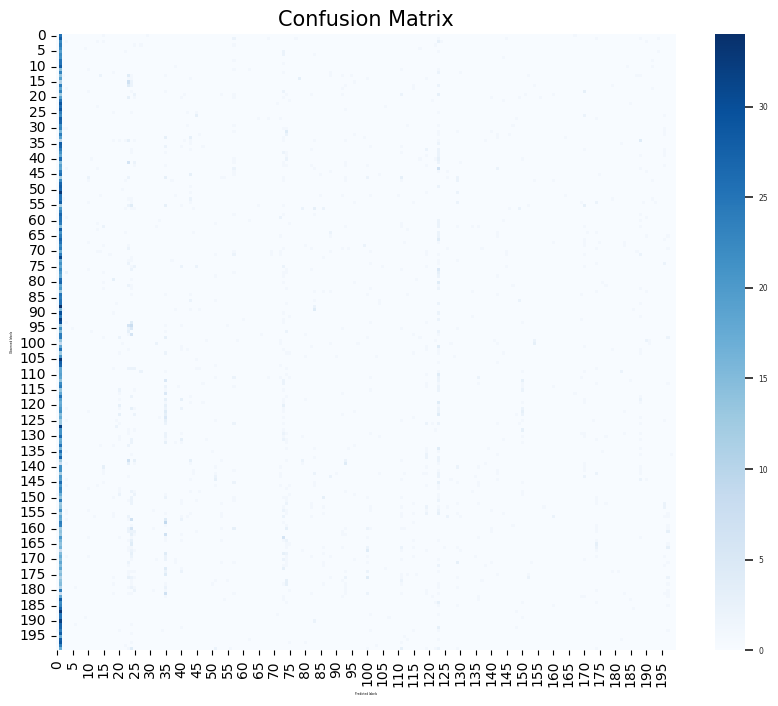

Ending Epoch: 1
Starting Epoch: 2
Size: 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


positive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0007_796138.jpgpositive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0019_796104.jpg

positive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0065_796068.jpgpositive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0024_796089.jpg
negative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/147.Least_Tern/Least_Tern_0012_153871.jpg

negative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/190.Red_cockaded_Woodpecker/Red_Cockaded_Woodpecker_0016_182493.jpg
negative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/163.Cape_May_Warbler/Cape_May_Warbler_0032_162659.jpgnegative image path: /content/drive/MyDrive/Datasets/CUB_200_2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


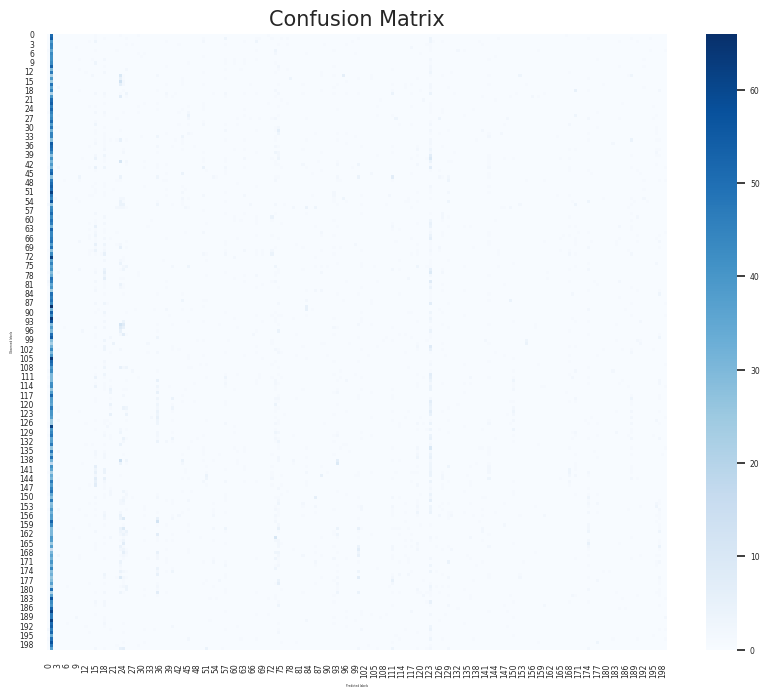

Ending Epoch: 2
Starting Epoch: 3
Size: 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


positive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0003_796136.jpgpositive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0053_796109.jpg

positive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0060_796076.jpgpositive image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0067_170.jpg

negative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/026.Bronzed_Cowbird/Bronzed_Cowbird_0032_796233.jpgnegative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/130.Tree_Sparrow/Tree_Sparrow_0036_122772.jpg

negative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/089.Hooded_Merganser/Hooded_Merganser_0076_796756.jpg
negative image path: /content/drive/MyDrive/Datasets/CUB_200_2011/images/041

In [ ]:

# input_size = (456, 456)
# Original
input_size = (224, 224)

# Load the dataset
dataset_path = '/content/drive/MyDrive/Datasets/CUB_200_2011/images/' if in_colab else './Datasets/CUB_200_2011/images/'

# without data augmentation
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# with data augmentation
# transform = transforms.Compose([
#     transforms.RandomResizedCrop(input_size),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

#with occlusion and data augmentation
#transform = transforms.Compose([
#    RandomOcclusion(occlusion_prob=0.5, max_occlusion_size=0.2),
#    transforms.RandomResizedCrop(input_size),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
#    transforms.RandomRotation(15),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#])

# possible color adjustments to be added (after RandomRotation beforeToTensor)
#    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust image color
#    transforms.RandomGrayscale(p=0.1),  # Randomly apply grayscale
#    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Apply perspective transformation

print('Preparing dataset')
dataset = datasets.ImageFolder(dataset_path, transform=transform)

print('Splitting dataset')
# Split the dataset into training and validation sets
train_size = int(0.6 * len(dataset))
val_size = int((len(dataset) - train_size)/2)
test_size = int((len(dataset) - train_size)/2)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# test_dataset 60% 20% 20%
# test_dataset 80% 10% 10%

# Occlusion added - masking
# Occlusion needs to be updated for the annotations / attributes (parts of bird)

batch_size = 3

print(train_dataset.dataset.samples[5])

print('Loader setup')

def get_train_dataset():
    return Dataset_Triplet(train_dataset, path=dataset_path, train=True, transform=transform)

train_dataset = get_train_dataset()

train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, num_workers=4, pin_memory=True)
# train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2) #shuffle - should the data be randomly shuffled during each epoch of training

val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

# Load the pre-trained model

def select_device():
    if torch.cuda.is_available():
        print('GPU is available')
        # Check if it's an Apple Silicon GPU
        if 'Metal' in torch.cuda.get_device_properties(0).name:
            selected_device = torch.device('metal')
        else:
            selected_device = torch.device('cuda')
    else:
        if torch.backends.mps.is_available():
            selected_device = torch.device('mps')
            print('GPU is available')
        else:
            selected_device = torch.device('cpu')
            print('GPU is not available')

    return selected_device

device = select_device()

print(f"Device: {device}")

# Used in saving the model as well
model_type = 'b0'

num_classes = 200

def set_baseline_model():
    my_model = EfficientNet.from_pretrained(f'efficientnet-{model_type}')
    for my_param in my_model.parameters():
        my_param.requires_grad = False

    # Unfreeze the last few layers (adjust as needed)
    for my_param in my_model._conv_head.parameters():
        my_param.requires_grad = True
    for my_param in my_model._bn1.parameters():
        my_param.requires_grad = True
    for my_param in my_model._fc.parameters():
        my_param.requires_grad = True
    my_model._fc = nn.Linear(my_model._fc.in_features, num_classes)
    return my_model

model = set_baseline_model()

# Print the model summary
print(torchinfo.summary(model))

# Loss functions, optimizer and scheduler
classification_criterion = nn.CrossEntropyLoss()
triplet_margin = 0.5
triplet_criterion = nn.TripletMarginLoss(margin=triplet_margin)

optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Early stopping parameters
patience = 5
early_stopping_counter = 0
best_loss = None

# Training loop
train_losses = []
val_losses = []

max_epoch = 5

all_predictions = []
all_labels = []

# Moved it down, because the model was in different device
model = model.to(device)

for epoch in range(max_epoch):  # Adjust as needed
    print(f'Starting Epoch: {epoch + 1}')
    train_loss = 0.0
    val_loss = 0.0

    # Training phase
    model.train()
    print(f'Size: {len(train_dataloader.dataset)}')
    start_time = time.time()
    for i, (anchor_img, positive_img, negative_img, anchor_labels) in enumerate(train_dataloader):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_labels = [int(label) for label in anchor_labels]
        anchor_labels = torch.tensor(anchor_labels, dtype=torch.long).to(device)

        optimizer.zero_grad()

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        classification_loss = classification_criterion(anchor_out, anchor_labels)

        triplet_loss = triplet_criterion(anchor_out, positive_out, negative_out)

        total_loss = classification_loss + triplet_loss

        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item() * anchor_img.size(0)
    end_time = time.time()
    #scheduler.step()

    execution_time = end_time - start_time
    print(f'Training {epoch + 1} took {execution_time} s')

    # Validation phase
    start_time_v = time.time()
    correct = 0
    total = 0
    top1_correct = 0
    top5_correct = 0
    model.eval()
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        #add triplet loss
        classification_loss = classification_criterion(outputs, labels)
        val_loss += classification_loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Calculate top-1 error
        top1_correct += predicted.eq(labels).sum().item()

        # Calculate top-5 error
        _, top5_predicted = outputs.topk(5, dim=1)
        top5_correct += top5_predicted.eq(labels.view(-1, 1)).sum().item()

        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    end_time_v = time.time()

    execution_time_v = end_time_v - start_time_v
    print(f'Validating {epoch + 1} took {execution_time_v} s')

    # Calculate average losses
    train_loss = train_loss / len(train_dataloader.dataset)
    val_loss = val_loss / len(val_dataloader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
    print(f'Accuracy: {100 * correct / total}%')

    # Compute and print Precision, Recall and F1-score
    # By using 'macro'-averaging, calculate metrics for each label and find their mean (instead of 'micro'-averaging which calculates metrics globally)
    # Warning: Be cautious with label imbalances
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1_score = 2 * precision * recall / (precision + recall)

    print(f"Precision={precision}, Recall={recall}, F1-Score={f1_score}")

    # Calculate top-1 error percentage
    top1_error = 100 * (1 - top1_correct / total)
    # Calculate top-5 error percentage
    top5_error = 100 * (1 - top5_correct / total)

    print(f'Top-1 Error: {top1_error}%')
    print(f'Top-5 Error: {top5_error}%')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sns.set(font_scale=0.5) # Adjust to fit
    sns.heatmap(conf_matrix, annot=False, ax=ax, cmap="Blues", fmt="g");

    # Labels, title and ticks for confusion matrix
    label_font = {'size':'2'}
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    title_font = {'size':'15'}
    ax.set_title('Confusion Matrix', fontdict=title_font);
    plt.show()

    # Check for early stopping - Maybe check PyTorch in-build early stopping mechanism
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print('Early stopping triggered')
        break
    print(f'Ending Epoch: {epoch + 1}')

# Plotting the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Convert lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Print or visualize the results
for i in range(len(all_predictions)):
    print(f"Sample {i + 1}: Predicted={all_predictions[i]}, Actual={all_labels[i]}")


#### Save Model

In [ ]:
# saving the trained baseline ENB{model_type} model
import time

def get_trained_model_path():
    return '/content/drive/MyDrive/TrainedModels' if in_colab else './TrainedModels'

trained_model_path = get_trained_model_path()

last_trained_model = int(time.time())

def generate_save_path(selected_model_type, replacer_value):
    common_save_path = f'{trained_model_path}/baseline_en{selected_model_type}_model_{last_trained_model}{replacer_value}.pth'
    return common_save_path

model_save_path_dict = generate_save_path(model_type, '_dict')

import os

if not os.path.exists(model_save_path_dict):
  os.makedirs(os.path.dirname(model_save_path_dict), exist_ok=True)

torch.save(model.state_dict(), model_save_path_dict)
print(f"Trained model saved at {model_save_path_dict}")

model_save_path = generate_save_path(model_type, '')

torch.save(model, model_save_path)
print(f"Trained model saved at {model_save_path}")

Trained model saved at ./TrainedModels/baseline_enb0_model_1699786114_dict.pth
Trained model saved at ./TrainedModels/baseline_enb0_model_1699786114.pth


#### Load from Model

In [ ]:
# Load the model from saved directory
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

# Set the path to the saved model
model_load_path_dict = f'{trained_model_path}/baseline_en{model_type}_model_{last_trained_model}_dict.pth'

model = set_baseline_model()

# Load the state dictionary into the model
model.load_state_dict(torch.load(model_load_path_dict))

# Set the model to evaluation mode (important if using layers like dropout)
model.eval()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded pretrained weights for efficientnet-b5


EfficientNetB5Model(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStat

In [ ]:
# Compute and print Precision and Recall
from sklearn.metrics import precision_score, recall_score

# By using 'macro'-averaging, calculate metrics for each label and find their mean (instead of 'micro'-averaging which calculates metrics globally)
# Warning: Be cautious with label imbalances
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')

print(f"Precision={precision}, Recall={recall}")

Precision=0.5426703253836185, Recall=0.5427008588461762


### Confusion Matrix

Confusion Matrix:
[[ 73  12  18 ...   0   0   0]
 [  5  64   7 ...   0   0   0]
 [  9   9  91 ...   0   0   0]
 ...
 [  0   0   1 ... 110   0   0]
 [  0   0   0 ...  15  72   0]
 [  0   0   0 ...   0   0  48]]


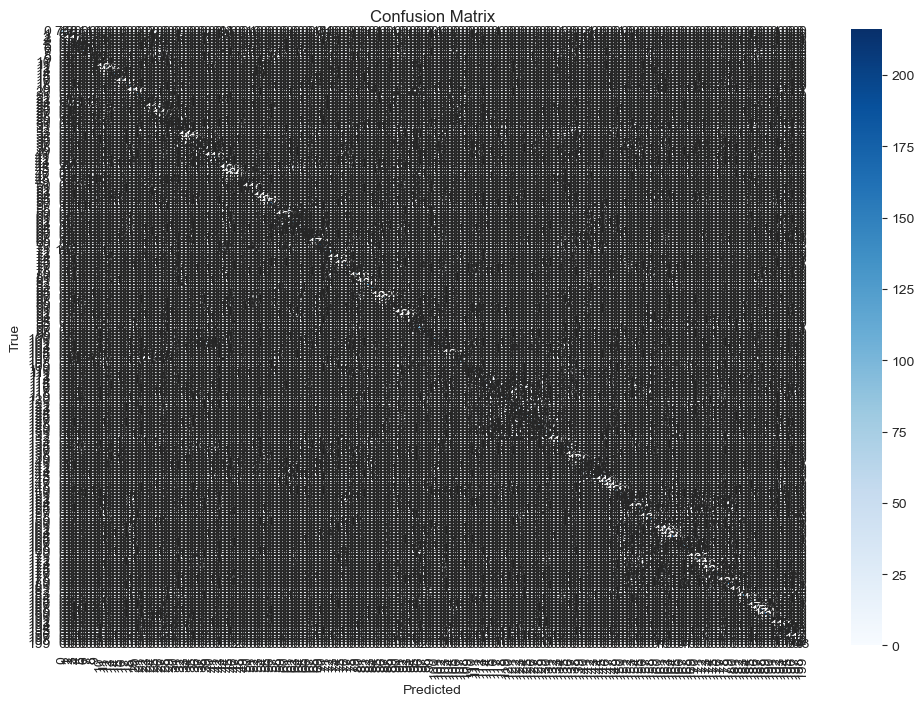

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
ax = plt.subplot()

sns.set(font_scale=0.5) # Adjust to fit
sns.heatmap(conf_matrix, annot=False, ax=ax, cmap="Blues", fmt="g");

# Labels, title and ticks for confusion matrix
label_font = {'size':'2'}
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'15'}
ax.set_title('Confusion Matrix', fontdict=title_font);
plt.show()

# cm = confusion_matrix(all_labels, all_predictions)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(cm)

# plt.figure(figsize=(12, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

#### **Step 3.1: Tweak Decoder - Fine Grained using Annotations**

In [ ]:
# Attributes txt [Parts of Bird] < Included!!!!!!

#### **Step 3.2: Include Loss Functions - Cross Entropy + Triplet Loss**

#### **Step 4: Calculate Training and Validation Loss**

#### **Step 5.1: Calculate Top-1, Top-5 Error**

#### **Step 5.2: Compare Custom CNN vs Baseline**

#### **Step 6: Benchmarking - mAP (mean average precision), F-Score**

#### **Step 7: Confusion Matrix b/w Similar Classes**

# Appendix

##### **Step 1.2: Divide the dataset in training, validation and testing datasets**

In [ ]:
# not needed at the moment
!pip install split-folders

In [ ]:
# not needed at the moment
import splitfolders

input = '/content/drive/MyDrive/Datasets/CUB_200_2011/images'
output ='/content/drive/MyDrive/Datasets/CUB_200_2011_divided'


# Set a tuple as "ratio" to split the dataset into training, validation and test set
# Other ratios to consider: .7, .15, .15 or .6, .2, .2
splitfolders.ratio(input, output=output, seed=42, ratio=(.8, .1, .1), group_prefix=None)


Copying files: 11788 files [01:47, 109.87 files/s]


## Baseline Version 1

In [ ]:
# Version 1

import torch

torch.hub._download_url_to_file = lambda url, filename, **kwargs: (filename, True)

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR

# Define constants
input_size = (456, 456)  # EfficientNetB5 input size
num_classes = 200  # Number of bird species in CUB-200-2011

from efficientnet_pytorch import EfficientNet

should_freeze_layer = False

# Create a basic EfficientNetB5 model
class EfficientNetB5Model(nn.Module):
    def __init__(self, num_classes, freeze_layers=True):
        super(EfficientNetB5Model, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=num_classes)
        if freeze_layers:
          for param in self.base_model.parameters():
              param.requires_grad = False

    def forward(self, x):
        return self.base_model(x)


# Create a basic EfficientNetB5 model - EFB5 from torchvision
# class EfficientNetB5Model(nn.Module):
#     def __init__(self, num_classes):
#         super(EfficientNetB5Model, self).__init__()
#         self.base_model = models.efficientnet_b5(pretrained=True)
#         in_features = self.base_model._fc.in_features
#         self.base_model._fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         return self.base_model(x)

# Instantiate the model
model = EfficientNetB5Model(num_classes, freeze_layers=should_freeze_layer)

# Set device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

torch.cuda.empty_cache()

# Print the model summary
print(model)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Implement gradient clipping to limit the magnitude of gradients during training. This can help prevent exploding gradients and save memory.
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Modify the data loading part
transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Specify the path to the dataset
dataset_path = '/content/drive/MyDrive/Datasets/CUB_200_2011/images/'

# Create the dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances for training and validation sets
# Changed batch size from 32 to 16 to 8 - it worked with 8 (12.4 GB GPU), failed with 32 & 16 because of out of memory
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

accumulation_steps = 2  # Accumulate gradients for every two batches

# Lists to store training and validation losses -- ADDED LATER (NEED TO RETRAIN)
train_losses = []
val_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Start of epoch: #{epoch + 1}')
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        # optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
         # Backward pass only for parameters that require gradients
        # if any(param.requires_grad for param in model.parameters()):
        #     loss.backward()
        #     optimizer.step()
        #     optimizer.zero_grad()
        # loss.backward() - Put inside if statement because freeze_layer True for some layers doesn't calculate the gradient
        # Accumulate gradients
        # if (i + 1) % accumulation_steps == 0:
        #     optimizer.step()
        #     optimizer.zero_grad()

        running_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # ADDED LATER - NEED TO RETRAIN
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    # Print statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%")

# Plot training and validation loss curves - ADDED LATER (NEED TO RETRAIN)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

print(f'End of epoch: #{epoch + 1}')


Loaded pretrained weights for efficientnet-b5
EfficientNetB5Model(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()

KeyboardInterrupt: ignored